# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044649864687342
RMSE when predicting testing data:
1.0666272939687746
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851473707103607


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289812, -1.0937049 , -1.08514737])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

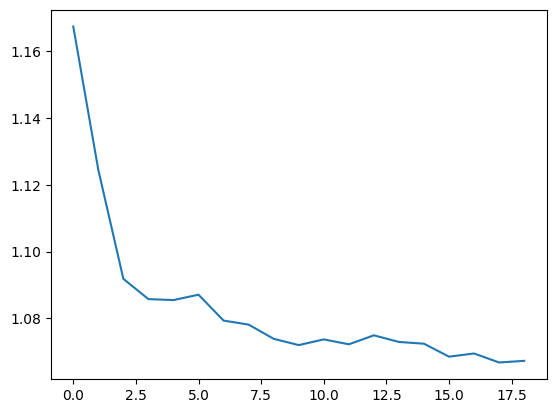

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

The above graph represents the RMSE values with respect to the number of features included in the training set. As the numbers of features increases, the model scoring improves. The best values in the chart lies at 17, meaning 17 features in the dataset provided the best results.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

** Prediction **

I predict that alpha = 10 will perform better than alpha = 0 because all columns have a so-called parent from the sythesized data.

** Actual **

After running through each iteration of different alpha valuesn alpha = 0 performed the best. 

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

def eval_model(alpha_ls):

    # dataframe to store results
    results_df = pd.DataFrame(columns = [
            'alpha',
            'n_estimators',
            'max_depth',
            'max_features',
            'mean_test_score',
            'std_test_score',
            'mean_train_score',
            'std_train_score',
            'test_rmse'
        ]
    )

    for x in alpha_ls:

        # Generate the data
        X, y = make_X_y(alpha=x)

        # split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        # Define the model
        forest_model = RandomForestRegressor(random_state=42)

        # Define the parameter grid
        param_dist = {
            'n_estimators': [10, 33, 100, 500],
            'max_depth' : range(1, 11),                      
            'max_features' : range(1, 11),
        }

        # Use RandomizedSearchCV to find the best parameters
        search = RandomizedSearchCV(
            estimator=forest_model,
            param_distributions=param_dist,
            scoring='neg_root_mean_squared_error',
            cv=5,
            n_jobs=-1,
            return_train_score=True
        )

        # Fit the RandomizedSearchCV
        search.fit(X_train, y_train)  

        # Extract results into a DataFrame
        results = pd.DataFrame(search.cv_results_)

        # Select relevant columns for readability
        results = results[[
            'param_n_estimators',
            'param_max_depth',
            'param_max_features',
            'mean_test_score',
            'std_test_score',
            'mean_train_score',
            'std_train_score',
            'rank_test_score'
        ]]

        # Convert negative MSE to positive
        results['mean_test_score'] = -results['mean_test_score']
        results['mean_train_score'] = -results['mean_train_score']

        # Sort by rank (best scores first)
        results = results.sort_values(by='rank_test_score')

        # Rename columns for printing only
        renamed_results = results.rename(
            columns={
                'param_n_estimators': 'n_estimators',
                'param_max_depth': 'max_depth',
                'param_max_features': 'max_features',
                'mean_test_score': 'mean_cv_score',
                'std_test_score': 'std_cv_score',
                'mean_train_score': 'mean_train_score',
                'std_train_score': 'std_train_score'
            }
        ).drop(columns=['rank_test_score'])  # Drop the rank column for readability

        # Evaluate on the test set using best estimator
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse = root_mean_squared_error(y_test, y_pred)

        # Add the alpha value and test rmse to the results for reference
        renamed_results['alpha'] = x
        renamed_results['test_rmse'] = test_rmse

        # Save the first row of the reanmed_results df to results_df
        renamed_results = renamed_results.head(1)

        # store the results in the dataframe
        if results_df.empty:
            results_df = renamed_results
        else:
            results_df = pd.concat([results_df, renamed_results])
                        
    # Print the results as a table
    print("\nSearch Results:\n")
    print(results_df.to_string(index=False))

        

In [53]:
# Evaluate on the test set using best estimator
eval_model(alpha_ls = [0,0.5,2.5,10])


Search Results:

 n_estimators  max_depth  max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score  alpha  test_rmse
           33          1             5       0.979772      0.016131          0.978625         0.003984    0.0   1.010404
          500          6             5       1.064772      0.025190          1.009506         0.005925    0.5   1.086740
          100          7            10       1.153868      0.012781          1.025813         0.002799    2.5   1.172611
          500          8             7       1.195718      0.016868          0.984729         0.003387   10.0   1.157557


# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

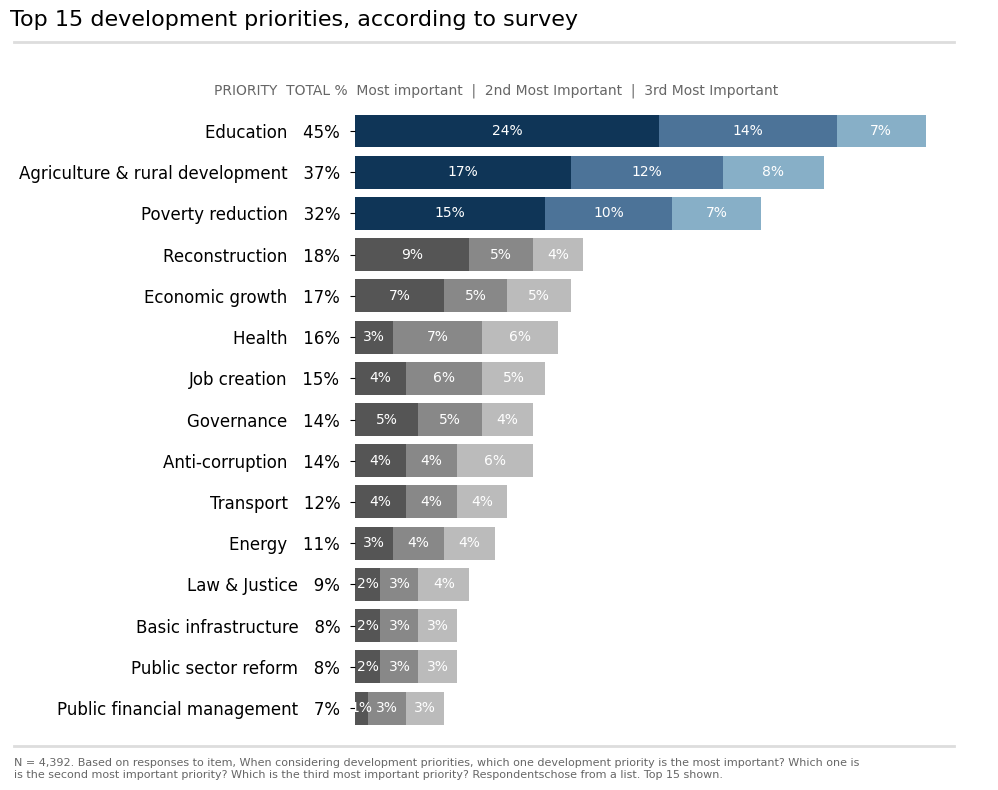

In [61]:
import numpy as np
from matplotlib.lines import Line2D

priorities = [
    ("Education",                       45, 24, 14,  7),
    ("Agriculture & rural development", 37, 17, 12,  8),
    ("Poverty reduction",               32, 15, 10,  7),
    ("Reconstruction",                  18,  9,  5,  4),
    ("Economic growth",                 17,  7,  5,  5),
    ("Health",                          16,  3,  7,  6),
    ("Job creation",                    15,  4,  6,  5),
    ("Governance",                      14,  5,  5,  4),
    ("Anti-corruption",                 14,  4,  4,  6),
    ("Transport",                       12,  4,  4,  4),
    ("Energy",                          11,  3,  4,  4),
    ("Law & Justice",                    9,  2,  3,  4),
    ("Basic infrastructure",             8,  2,  3,  3),
    ("Public sector reform",             8,  2,  3,  3),
    ("Public financial management",      7,  1,  3,  3),
]

labels, total, most, second, third = zip(*priorities)
N = len(labels)
y = np.arange(N)

# Highlight top 3 in shades of blue, rest in greys
blue = ["#0F3557", "#4C7398", "#87AFC7"]
grey = ["#555555", "#888888", "#BBBBBB"]

# Make a color list parallel to our data
c1 = [blue[0]   if i<3 else grey[0]   for i in range(N)]  # Most important
c2 = [blue[1]   if i<3 else grey[1]   for i in range(N)]  # 2nd most
c3 = [blue[2]   if i<3 else grey[2]   for i in range(N)]  # 3rd most

fig, ax = plt.subplots(figsize=(10, 8))

# First stack: “Most important”
ax.barh(y, most,  color=c1, edgecolor="none", label="Most important")
# Second stack: “2nd most important”
ax.barh(y, second, left=most, color=c2, edgecolor="none", label="2nd most important")
# Third stack: “3rd most important”
ax.barh(y, third,  left=np.array(most)+np.array(second),
        color=c3, edgecolor="none", label="3rd most important")

# Priority names on the left
ax.set_yticks(y)
combined_labels = [f"{lbl}   {tot}% " for lbl, tot in zip(labels, total)]
ax.set_yticklabels(combined_labels, fontsize=12)

# In‑bar % labels
for i in range(N):
    ax.text(most[i]/2, i, f"{most[i]}%",
        va="center", ha="center", color="white", fontsize=10)
    ax.text(most[i] + second[i]/2, i, f"{second[i]}%",
        va="center", ha="center", color="white", fontsize=10)
    ax.text(most[i] + second[i] + third[i]/2, i,
        f"{third[i]}%", va="center", ha="center", color="white", fontsize=10)

# invert so highest priority is on top
ax.invert_yaxis()

# remove all spines/ticks
ax.set_xlim(0, 50)
ax.xaxis.set_visible(False)
for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(False)

# get the axes bounding box in figure coords
box = ax.get_position()

fig.text(
    .21, box.y1 - .01,
    "PRIORITY  TOTAL %  Most important  |  2nd Most Important  |  3rd Most Important",
    ha='left', va="bottom",
    fontsize=10, color="#666"
)

plt.suptitle("Top 15 development priorities, according to survey",
             x=0.29, y=0.98, fontsize=16)

# Footnote
fig.text(0.01, 0.02,
         "N = 4,392. Based on responses to item, When considering development priorities, which one development priority is the most important? Which one is\n"
         "is the second most important priority? Which is the third most important priority? Respondentschose from a list. Top 15 shown.",
         fontsize=8, color="#666")

divider_color = "#DDDDDD"

# y‑positions in figure coordinates (0 = bottom, 1 = top)
y_top    = 0.94
y_bottom = 0.06

# full‑width lines across the figure
line_top = Line2D([0.01, 0.95], [y_top,    y_top],    transform=fig.transFigure,
                  color=divider_color, linewidth=2)
line_bot = Line2D([0.01, 0.95], [y_bottom, y_bottom], transform=fig.transFigure,
                  color=divider_color, linewidth=2)

fig.add_artist(line_top)
fig.add_artist(line_bot)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
